In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tabulate import tabulate
from IPython.display import display, HTML
from google.colab import files
import io
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
!pip install -U lazyme
from lazyme.string import color_print
from sklearn.utils import resample

In [ ]:
def upload_df(dataset_name):

    uploaded = files.upload()
    df = pd.read_csv(io.BytesIO(uploaded[dataset_name]))
    try: 
        df.drop('Unnamed: 0', axis=1, inplace=True)
    except:
        pass
    display(HTML(df.head().to_html()))
    return df

In [ ]:
def save_df(df, file_name):

    df.to_csv(file_name)
    files.download(file_name)

In [ ]:
class PrepareClassificationData:

    def __init__(self, df):
        self.df = df
        # the new df, ready for clf
        self.df_md = None 
        # the new upsampled df, ready for clf
        self.df_upsampled = None
        self.run()

    def run(self):
        self.group_by_max_discount()
        self.data_preprocessing()
        self.resample()
        self.save_data_for_classification()
        self.save_resample_data_for_classification()

    def group_by_max_discount(self):
        # Look for the maximum discount code by the groupby function
        df_md = self.df.groupby(['Snapshot Date', 'Checkin Date', 'DayDiff', 'Hotel Name', 'WeekDay'])
        df_md = self.df.loc[df_md['DiscountPerc'].idxmax()]
        df_md = df_md[['Snapshot Date','Checkin Date','DayDiff','Hotel Name','WeekDay', 'DiscountPerc', 'Discount Code']].dropna(axis=0, how='any')
        self.df_md = df_md

    def data_preprocessing(self):
        # For the next columns 'Hotel Name', 'WeekDay', 'Snapshot Date', 'Checkin Date' Change the column values from strings to numeric values
        self.df_md['Hotel Name'] = preprocessing.LabelEncoder().fit(self.df_md['Hotel Name']).transform(self.df_md['Hotel Name']) 
        self.df_md['WeekDay'] = preprocessing.LabelEncoder().fit(self.df_md['WeekDay']).transform(self.df_md['WeekDay']) 
        self.df_md['Snapshot Date'] = preprocessing.LabelEncoder().fit(self.df_md['Snapshot Date']).transform(self.df_md['Snapshot Date']) 
        self.df_md['Checkin Date'] = preprocessing.LabelEncoder().fit(self.df_md['Checkin Date']).transform(self.df_md['Checkin Date']) 
        mms = MinMaxScaler()
        self.df_md[['Hotel Name', 'WeekDay', 'Snapshot Date', 'Checkin Date']] = mms.fit_transform(self.df_md[
          ['Hotel Name', 'WeekDay', 'Snapshot Date', 'Checkin Date']])
        color_print('DF after preprocessing:', color='black', highlight='yellow', bold=True)
        display(HTML(self.df_md.head().to_html()))

    def resample(self):
        # figure out how to resamble
        print('\n'*2)
        color_print('Before resampling:', color='black', highlight='yellow', bold=True)
        self.y_distribution(self.df_md)
        df_minority1 = self.df_md[self.df_md['Discount Code'] == 1]
        df_minority3 = self.df_md[self.df_md['Discount Code'] == 3]
        df_minority4 = self.df_md[self.df_md['Discount Code'] == 4]
        df_majority = self.df_md[self.df_md['Discount Code'] == 2]
        # resample
        df_minority_upsampled1 = resample(df_minority1, replace = True, n_samples = len(df_majority) - len(df_minority1))
        df_minority_upsampled3 = resample(df_minority3, replace = True, n_samples = len(df_majority) - len(df_minority3))
        df_minority_upsampled4 = resample(df_minority4, replace = True, n_samples = len(df_majority) - len(df_minority4))
        df_upsampled = pd.concat([self.df_md, df_minority_upsampled1])
        df_upsampled = pd.concat([df_upsampled, df_minority_upsampled3])
        df_upsampled = pd.concat([df_upsampled, df_minority_upsampled4])
        self.df_upsampled = df_upsampled
        print('\n'*2)
        color_print('After resampling:', color='black', highlight='yellow', bold=True)
        self.y_distribution(self.df_upsampled)
        
    def save_data_for_classification(self):
        save_df(self.df_md, 'classification_data.csv')

    def save_resample_data_for_classification(self):
        save_df(self.df_upsampled, 'upsampled_classification_data.csv')

    def y_distribution(self, df):
        sns.barplot(x=[1, 2, 3, 4], y=df.groupby(['Discount Code']).size())
        # Add labels to your graph
        plt.ylabel('Appearance')
        plt.xlabel('Discount Codes')
        plt.title("Discount Codes appearance numbers")
        plt.show()

In [ ]:
# upload the data for clf preparation
df = upload_df('Hotels_data_cleaned.csv')

Saving Hotels_data_cleaned.csv to Hotels_data_cleaned.csv


,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc
0,1,2015-07-17,2015-08-12,5,1178,6.946976,1,6,Best Western Plus Seaport Inn Downtown,3,26,Wednesday,4.927254,2.460851
1,1,2015-07-17,2015-08-19,5,1113,6.889591,1,8,Best Western Plus Seaport Inn Downtown,3,33,Wednesday,4.875197,2.465553
2,1,2015-07-17,2015-08-13,5,4370,8.352319,1,3,The Peninsula New York,5,27,Thursday,4.867534,1.090186
3,1,2015-07-17,2015-07-26,5,1739,7.418781,1,18,Eventi Hotel a Kimpton Hotel,4,9,Sunday,4.276666,1.420771
4,1,2015-07-17,2015-08-12,5,1739,7.421776,1,3,Eventi Hotel a Kimpton Hotel,4,26,Wednesday,4.204693,1.348797


DF after preprocessing:


,Snapshot Date,Checkin Date,DayDiff,Hotel Name,WeekDay,DiscountPerc,Discount Code
347,0.0,0.0,1,0.403255,0.333333,2.375156,2
363,0.0,0.0,1,0.477396,0.333333,1.795402,2
327,0.0,0.0,1,0.591320,0.333333,2.579217,2
260,0.0,0.0,1,0.616637,0.333333,0.994252,2
94,0.0,0.0,1,0.652803,0.333333,2.956512,1





Before resampling:


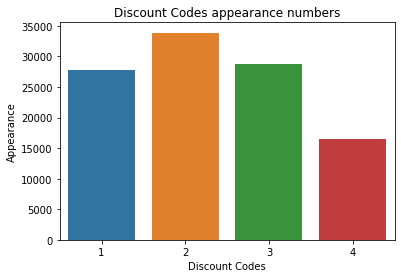




After resampling:


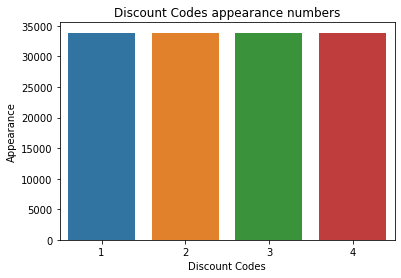

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# run clf preparation
PrepareClassificationData(df)